# Dataset 2: Language Classification

**Task:** Given a short text snippet, predict its **language**.

**Dataset format:** Each row contains:
1. `Text` (string): the input text snippet
2. `language` (string): the language label associated with the text

**Why this is a classification problem:** The output we are predicting is one label from a set of languages.

In [3]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, classification_report,confusion_matrix,)
from sklearn.svm import LinearSVC

In [4]:
df = pd.read_csv("text_data.csv")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
display(df.head())

Shape: (22000, 2)
Columns: ['Text', 'language']


,Text,language
0,klement gottwaldi surnukeha palsameeriti ning ...,Estonian
1,sebes joseph pereira thomas på eng the jesuit...,Swedish
2,ถนนเจริญกรุง อักษรโรมัน thanon charoen krung เ...,Thai
3,விசாகப்பட்டினம் தமிழ்ச்சங்கத்தை இந்துப் பத்திர...,Tamil
4,de spons behoort tot het geslacht haliclona en...,Dutch


## Data Exploration

Checking the following: 

**Dataset size and schema** (rows/columns, label column, text column) to choose feasible model complexity.

**Missing values and empty strings** because vectorizers can break or create features that harm metrics if empty text exists.

**Duplicates** because duplicates can inflate results if they appear in both train and test splits; possible leakage

**Class balance** because imbalance can hide weak performance on minority languages even if accuracy is high.

**Text length** distribution overall and by class because it motivates using character n-grams (short texts often lack enough word context) and helps choose a reasonable n-gram range.

Number of samples: 22000
Number of raw features (columns): 2
Missing fraction in 'Text': 0.0
Missing fraction in 'language': 0.0
Duplicate rows: 141

Label distribution (top 10):


language
Estonian    1000
Swedish     1000
English     1000
Russian     1000
Romanian    1000
Persian     1000
Pushto      1000
Spanish     1000
Hindi       1000
Korean      1000
Name: count, dtype: int64

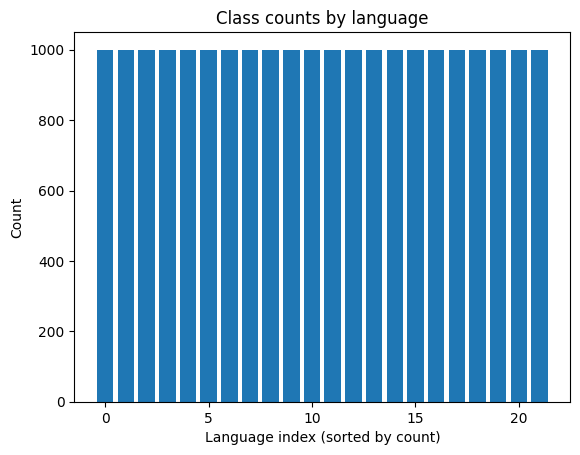

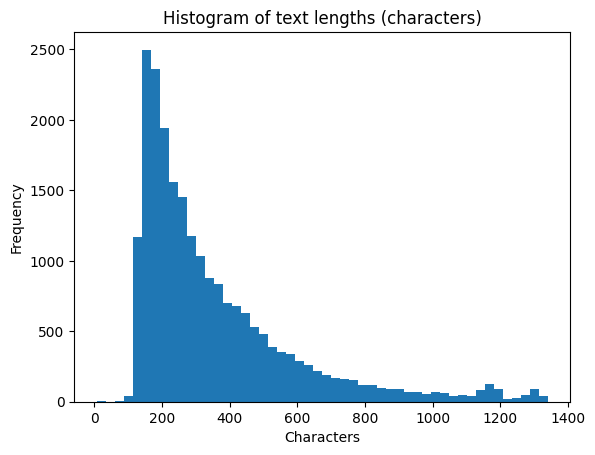

,count,mean,std,min,25%,50%,75%,max
language,,,,,,,,
Arabic,1000.0,406.873,256.209758,104.0,216.00,331.5,501.25,1327.0
Chinese,1000.0,233.785,114.507252,88.0,161.00,200.5,262.25,1217.0
Turkish,1000.0,377.937,239.958140,107.0,207.75,300.0,468.25,1313.0
Thai,1000.0,362.224,214.036804,110.0,204.75,303.0,452.00,1317.0
Tamil,1000.0,351.336,197.815369,123.0,205.00,293.0,454.25,1330.0
Swedish,1000.0,316.272,175.295980,128.0,190.00,280.0,384.50,1307.0
Spanish,1000.0,383.995,235.792899,124.0,211.50,314.0,485.00,1310.0
Russian,1000.0,391.592,265.257526,83.0,196.00,299.5,503.25,1307.0
Romanian,1000.0,334.297,218.257750,120.0,179.00,253.0,419.00,1260.0


In [6]:
def frac_missing(s: pd.Series) -> float:
    return float(s.isna().mean())

print("Number of samples:", len(df))
print("Number of raw features (columns):", df.shape[1])

for col in df.columns:
    print(f"Missing fraction in {col!r}:", frac_missing(df[col]))

dup_rows = df.duplicated().sum()
print("Duplicate rows:", int(dup_rows))

text_col = "Text"
label_col = "language"

print("\nLabel distribution (top 10):")
display(df[label_col].value_counts().head(10))

# Plot class balance
counts = df[label_col].value_counts().sort_values(ascending=False)

plt.figure()
plt.bar(range(len(counts)), counts.values)
plt.title("Class counts by language")
plt.xlabel("Language index (sorted by count)")
plt.ylabel("Count")
plt.show()

# Plot text length histogram
text_lengths = df[text_col].astype(str).map(len)

plt.figure()
plt.hist(text_lengths.values, bins=50)
plt.title("Histogram of text lengths (characters)")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.show()

# Quick view of length by class (box-like summary in a table)
length_summary = (
    df.assign(_len=text_lengths)
      .groupby(label_col)["_len"]
      .describe()[["count", "mean", "std", "min", "25%", "50%", "75%", "max"]]
      .sort_values("count", ascending=False)
)
display(length_summary.head(10))


## Section 2

### 2.1 Preprocessing
We apply minimal text cleaning:
1. Strip leading and trailing whitespace.
2. Normalize internal whitespace.

There is no need for heavy normalization because we don't want to accidently change the meaning of the text, or interpretation

### 2.2 How we avoid data leakage
1. We create a train test split before fitting TF IDF or any model.
2. TF IDF is placed inside an sklearn `Pipeline`, so during cross validation the vectorizer is fit only on the training fold.
3. We use `StratifiedKFold` so each fold keeps similar class proportions.
4. We do not use any test set statistics for preprocessing or tuning.

### 2.3 Why both a single split and KFold
Even with a large dataset, we use:
1. One holdout test split, for a final unbiased metric after all tuning choices are fixed.
2. KFold cross validation on the training set, to tune hyperparameters more reliably than a single validation split.


In [8]:
def clean_text(s: str) -> str:
    if s is None:
        return ""
    s = str(s)
    s = s.strip()
    # normalize whitespace
    s = re.sub(r"\s+", " ", s)
    return s

df[text_col] = df[text_col].map(clean_text)

# Drop empty texts after cleaning
before = len(df)
df = df[df[text_col].str.len() > 0].copy()
after = len(df)
print("Dropped empty-text rows:", before - after)
print("New shape:", df.shape)

# Recompute missingness after cleaning
print("Missing fraction (post-clean) Text:", frac_missing(df[text_col]))
print("Missing fraction (post-clean) label:", frac_missing(df[label_col]))


Dropped empty-text rows: 1
New shape: (21999, 2)
Missing fraction (post-clean) Text: 0.0
Missing fraction (post-clean) label: 0.0


In [9]:
X = df[text_col].astype(str).values
y = df[label_col].astype(str).values

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))


Train size: 17599
Test size: 4400


## Feature Extraction/Feature Learning

We use a lot of feature extraction in this dataset, with the use of character N-grams

**Why we used N-Gram**:
Languages have distinctive spelling and character patterns. Character n-grams can capture these patterns even when the text is short or contains unique words which makes them a very strong tool in feature extraction for language classification. 
Decision links:

Since text are short and diverse, n-gram works the best for feature extraction.

#### Things to note

Earlier we have seen that there was only 1 sample with missing data which has been dropped

We also saw that all classes have exactly 1000 samples corresponding with them, so classes are of equal size

    - This is a useful insight for SVM's which would perform very bad if there was heavy class imbalance. 
      SVM's margin will favor towards the class with a larger number of samples as predicting the bigger class 
      the majority of the time, will net you a solution that is right the majority of the time.

# Machine Learning Methods: Multinomial Naive Bayes and SVM (One vs Rest)

## Multinomial Naive Bayes

[1] [2] [4] [6]

We chose **Multinomial Naive Bayes** because it’s a good **baseline** for text classification with sparse count or TF-IDF features (like n-grams). It handles high-dimensional sparse vectors very efficiently, trains quickly, and it's performance can tell us a lot about the underlying relationships of the data (How seperable/independent the classes are.) 

It gives us a simple method to compare against a stronger model like a SVM.

In [14]:
# TF-IDF (char n-grams) -> Multinomial Naive Bayes
nb_pipeline = Pipeline(steps=[
    ("tfidf", TfidfVectorizer(
        analyzer="char",
        ngram_range=(3, 5),
        lowercase=True,
        min_df=2,            # ignore very rare n-grams
        max_features=200000, # cap feature space
        dtype=np.float32     # smaller memory footprint, included for speed
    )),
    ("clf", MultinomialNB())
])

# Hyperparameter tuning (NB smoothing)
param_grid = {
    "clf__alpha": [0.1, 0.3, 0.5, 1.0],
    "clf__fit_prior": [True]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

nb_grid = GridSearchCV(
    estimator=nb_pipeline,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True
)

# Fit on training data
nb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ................clf__alpha=0.3, clf__fit_prior=True; total time= 1.3min
[CV] END ................clf__alpha=0.5, clf__fit_prior=True; total time= 1.3min
[CV] END ................clf__alpha=0.5, clf__fit_prior=True; total time= 1.3min
[CV] END ................clf__alpha=0.1, clf__fit_prior=True; total time= 1.5min
[CV] END ................clf__alpha=0.3, clf__fit_prior=True; total time= 1.5min
[CV] END ................clf__alpha=0.1, clf__fit_prior=True; total time= 1.5min
[CV] END ................clf__alpha=0.3, clf__fit_prior=True; total time= 1.5min
[CV] END ................clf__alpha=0.1, clf__fit_prior=True; total time= 1.5min
[CV] END ................clf__alpha=0.5, clf__fit_prior=True; total time=  20.7s
[CV] END ................clf__alpha=1.0, clf__fit_prior=True; total time=  20.1s
[CV] END ................clf__alpha=1.0, clf__fit_prior=True; total time=  20.2s
[CV] END ................clf__alpha=1.0, clf__fit

,estimator,Pipeline(step...inomialNB())])
,param_grid,"{'clf__alpha': [0.1, 0.3, ...], 'clf__fit_prior': [True]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


In [15]:
print("Best CV accuracy:", nb_grid.best_score_)
print("Best params:", nb_grid.best_params_)

best_model = nb_grid.best_estimator_
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("\nTest accuracy:", acc)
print("\nClassification report:")
print(classification_report(y_test, y_pred))

Best CV accuracy: 0.970282350561514
Best params: {'clf__alpha': 0.1, 'clf__fit_prior': True}

Test accuracy: 0.9729545454545454

Classification report:
              precision    recall  f1-score   support

      Arabic       0.97      1.00      0.99       200
     Chinese       1.00      0.84      0.92       200
       Dutch       0.97      0.99      0.98       200
     English       0.71      1.00      0.83       200
    Estonian       1.00      0.95      0.98       200
      French       0.96      0.99      0.98       200
       Hindi       1.00      0.97      0.99       200
  Indonesian       0.99      0.97      0.98       200
    Japanese       0.99      0.97      0.98       200
      Korean       1.00      0.98      0.99       200
       Latin       0.97      0.92      0.94       200
     Persian       1.00      0.99      0.99       200
   Portugese       0.98      0.95      0.97       200
      Pushto       1.00      0.96      0.98       200
    Romanian       1.00      0.98    

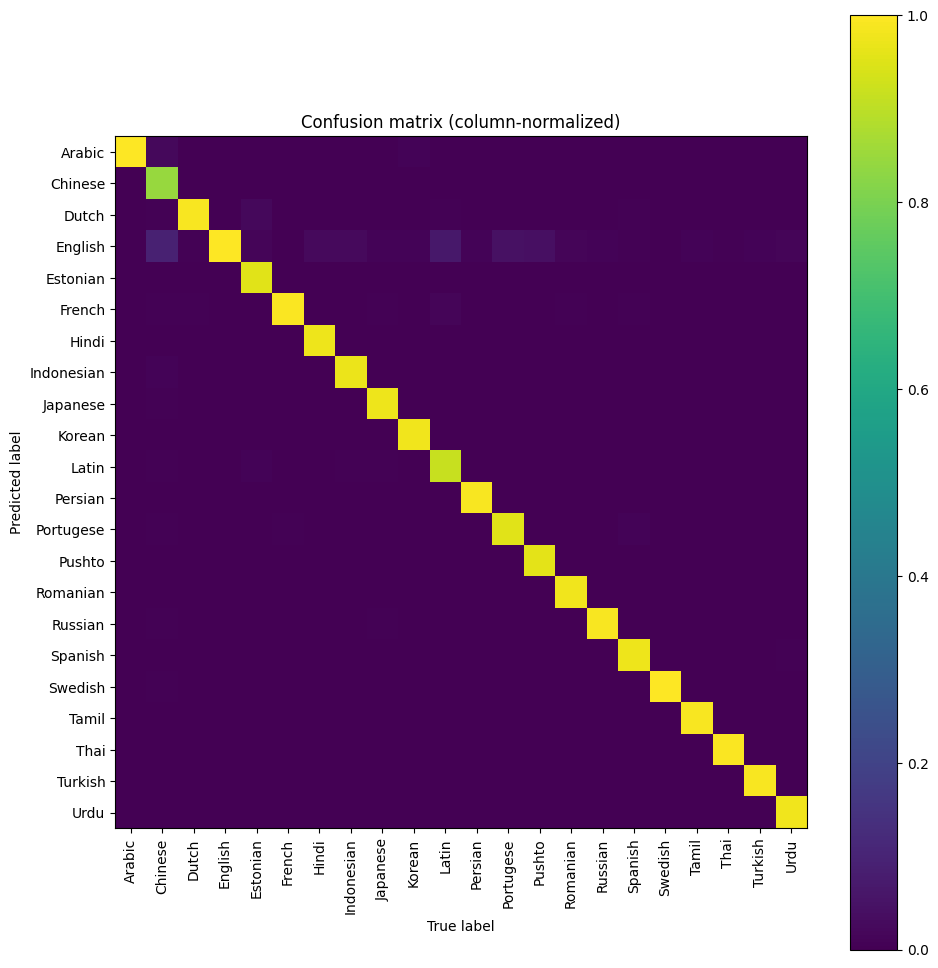

In [16]:
def plot_confusion_matrix_column_normalized(y_true, y_pred, title="Confusion matrix (column-normalized)"):
    labels = np.unique(np.concatenate([y_true, y_pred]))
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    cm_T = cm.T.astype(float)
    col_sums = cm_T.sum(axis=0, keepdims=True)
    col_sums[col_sums == 0] = 1.0
    cm_norm = cm_T / col_sums

    plt.figure(figsize=(10, 10))
    plt.imshow(cm_norm, interpolation="nearest")
    plt.title(title)
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.yticks(np.arange(len(labels)), labels)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

plot_confusion_matrix_column_normalized(y_test, y_pred)

## SVM (One-Vs-Rest)

[1] [3] [4] [6] 

For the second method, we use a **Linear Support Vector Machine (SVM) with a One-vs-Rest (OvR) strategy**. In OvR, one SVM is trained for each language to separate that language from all others. During prediction, the input text is evaluated by all SVMs, and the language whose SVM produces the highest decision score is selected as the final prediction.

A linear SVM is well-suited for TF-IDF character n-gram features because the feature space is high-dimensional and sparse. The regularization parameter \( C \) is tuned using cross-validation.

We chose an **OVR** approach as a result of our Naive Bayes approach. Because Naive Bayes returned a high accuracy, it is safe to assume the classes are pretty seperable. This makes an OVR approach better than an OVO approach as now we can focus on seperating what makes one class unique from the others rather than having to find the nuances between classes.


#### Side Note

OVR models are more expensive individually than the OVO models, but also have a lot fewer models compared to OVO.

Best Crossval accuracy (SVM): 0.9867606532832486
Best params (SVM): {'clf__C': 10.0}
Test accuracy (SVM): 0.9879545454545454
Classification report (SVM):
              precision    recall  f1-score   support

      Arabic       1.00      1.00      1.00       200
     Chinese       0.98      0.98      0.98       200
       Dutch       1.00      1.00      1.00       200
     English       0.88      1.00      0.94       200
    Estonian       1.00      0.99      1.00       200
      French       0.98      0.99      0.99       200
       Hindi       1.00      0.98      0.99       200
  Indonesian       1.00      0.97      0.98       200
    Japanese       1.00      0.99      0.99       200
      Korean       1.00      0.98      0.99       200
       Latin       0.97      0.98      0.98       200
     Persian       0.99      0.99      0.99       200
   Portugese       0.98      0.98      0.98       200
      Pushto       0.99      0.96      0.97       200
    Romanian       1.00      0.99  

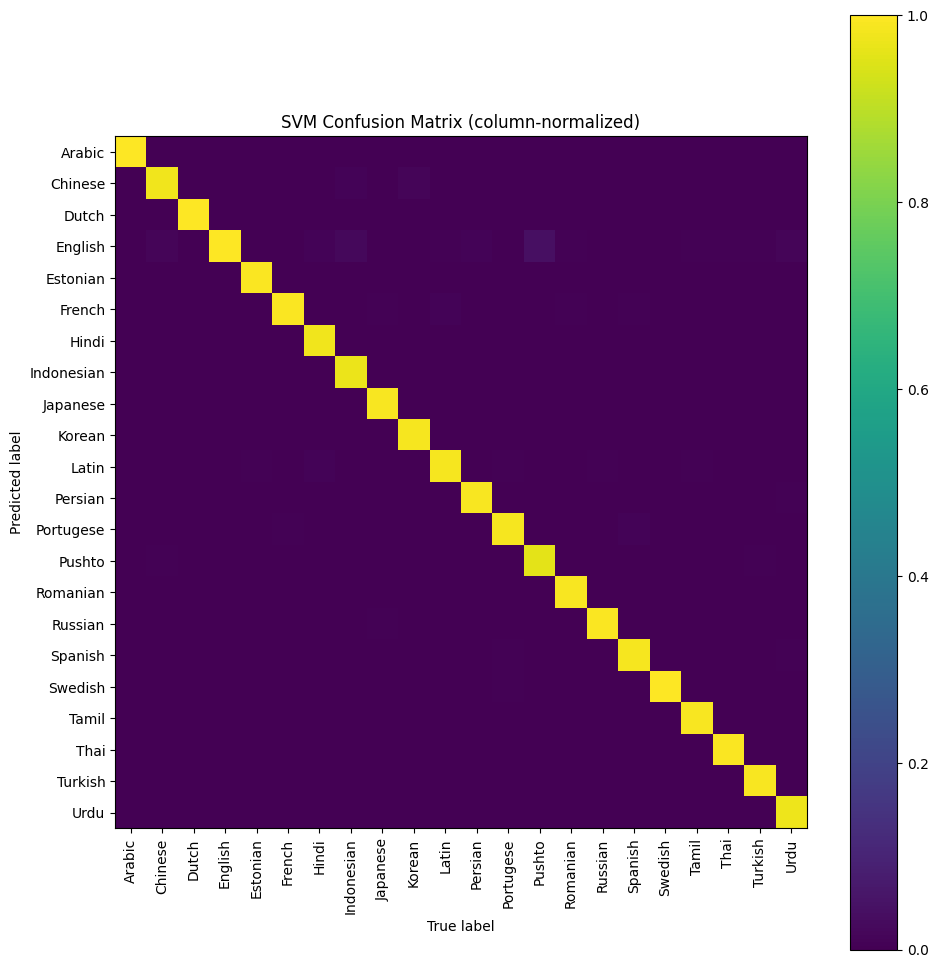

In [19]:
svm_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(   #tfidf turn raw text into numbers for ML (high weight to character patterns that appear often in one language but not in all languages)
        analyzer="char",
        ngram_range=(3, 5), #range of chars: "que" "the", "tion" "ción"
        lowercase=True, 
        min_df=2,
        max_features=200000   #top 200k most frequent n-grams.
    )),
    ("clf", LinearSVC())  #OVR by default
])

# cross val + hyperparameter tuning
svm_param_grid = {
    "clf__C": [0.1, 1.0, 10.0]    #bigger c -> smaller margin
}

svm_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

svm_grid = GridSearchCV(
    svm_pipeline,
    svm_param_grid,
    scoring="accuracy",
    cv=svm_cv,
    n_jobs=-1
)

svm_grid.fit(X_train, y_train)

print("Best Crossval accuracy (SVM):", svm_grid.best_score_)
print("Best params (SVM):", svm_grid.best_params_)

# test 
best_svm = svm_grid.best_estimator_
y_pred_svm = best_svm.predict(X_test)

print("Test accuracy (SVM):", accuracy_score(y_test, y_pred_svm))
print("Classification report (SVM):")
print(classification_report(y_test, y_pred_svm))

plot_confusion_matrix_column_normalized(
    y_test,
    y_pred_svm,
    title="SVM Confusion Matrix (column-normalized)"
)

## Comparative Analysis: Naive Bayes vs SVM

### 5.1 Performance Comparison

In [22]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["Naive Bayes (MultinomialNB)", "Linear SVM (LinearSVC, OvR)"],
    "Best CV Accuracy": [0.9701, 0.9867],
    "Test Accuracy": [0.9732, 0.9880],
    "Macro F1": [0.97, 0.99],
    "English Precision": [0.71, 0.88],
    "English Recall": [1.00, 1.00],
})

results


,Model,Best CV Accuracy,Test Accuracy,Macro F1,English Precision,English Recall
0,Naive Bayes (MultinomialNB),0.9701,0.9732,0.97,0.71,1.0
1,"Linear SVM (LinearSVC, OvR)",0.9867,0.9880,0.99,0.88,1.0


### 5.2 Complexity and Runtime 

In [50]:
best_models = {
    "Multinomial Naive Bayes (CV best)": nb_grid.best_estimator_,
    "Linear SVM (CV best)": svm_grid.best_estimator_,
}

timing_rows = []

for model_name, estimator in best_models.items():
    fit_start = time.perf_counter()
    estimator.fit(X_train, y_train)
    fit_end = time.perf_counter()

    pred_start = time.perf_counter()
    _ = estimator.predict(X_test)
    pred_end = time.perf_counter()

    timing_rows.append({
        "Model": model_name,
        "Fit time (s)": fit_end - fit_start,
        "Predict time (s)": pred_end - pred_start
    })

pd.DataFrame(timing_rows)


,Model,Fit time (s),Predict time (s)
0,Multinomial Naive Bayes (CV best),13.466297,1.703890
1,Linear SVM (CV best),22.346528,1.709818


#### Complexity and Runtime Analysis

[2] [3]

Naive Bayes is typically faster to train and predict because it computes simple probability scores. In this case, Naive Bayes was ~50% faster than SVM in training (13.46 vs 22.34)

Linear SVM usually requires more computation to train because it optimizes a separating boundary, but prediction is still fast once trained. (In this case both essentially predict at the same speed)

Since both models use the same TF-IDF features, the main runtime difference comes from the learning algorithm: Naive Bayes is lightweight, while Linear SVM is slightly heavier but has better accuracy


### 5.3 Final recommendation

Based on both performance and robustness, Linear SVM is the recommended model for deployment on this dataset. It achieves the best overall accuracy and improves confusing cases (reducing non-English texts being predicted as English). Naive Bayes is also great especially when training time is of concern, but in most cases training time is less important than model prediction metrics (to an extent of course). 

**We can strongly recommend SVM as it provides the most reliable final results for language identification**.


#### Why this recommendation makes sense:

[2] [3] [5]

**Naive Bayes** assumes each feature is conditionally independent. In this case however, that is a false assumption.

While the characters of the languages are very different, n-grams (especially character n-grams) create features that overlap and co-occur. Adjacent n-grams share many of the same characters, and certain patterns tend to appear together, so the features aren’t truly independent.

Also, with TF-IDF, we’re weighting n-grams by “term importance,” but those weighted features are still correlated because overlapping n-grams often rise and fall together.

**SVM** doesn’t have this independence assumption. Instead, as we learned in class, SVMs run very well on sparse feature spaces.

When using n-grams, the feature space is often very sparse since thousands of features are created and most are zero for any given sample.

With this sparsity, many classes become closer to linearly separable, and a soft-margin SVM can still handle overlap by allowing a small number of violations while learning a strong separating boundary.

## 6. Ethical Considerations


**Communication Issues**: A model that identifies language is useful for tasks suchas content moderation, translation systems, and information access. But an incorrect prediction can still have ethical problems. For example, missclassification of a user's language could lead to a post being moderated incorrectly, a user might get the wrong translation or a system might treat users differently based on a wrong guess. These errors are more likely for languages that share similar spelling patterns.

**Data Collection**. If someone’s language is detected, a system may start making assumptions about their background, such as ethnicity or nationality. If this language data is collected without consent and combined with other user data, it can be used to build a detailed profile of someone without their knowledge. That creates privacy risks and increases the chance of sensitive personal information being leaked.

That is why this system should be used as a tool rather than a fully automated decusion maker, with awarness of its limitations and biases. A careful deployment and evaluation are necessary to ensure responsible and ethical use.

## Section 7

[1] scikit-learn documentation, “TfidfVectorizer.”
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

[2] scikit-learn documentation, “Multinomial Naive Bayes.”
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

[3] scikit-learn documentation, “Linear Support Vector Classification (LinearSVC).”
https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

[4] scikit-learn documentation, “GridSearchCV.”
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

[5] Jurafsky, D. and Martin, J. H., *Speech and Language Processing*, Pearson.
https://web.stanford.edu/~jurafsky/slp3/

[6] scikit-learn documentation, "Pipeline"
https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html